In [8]:
import os, sys

import pandas as pd
import numpy as np
from tqdm import tqdm
import optuna

#add ../ to path
sys.path.append(os.path.join(os.path.dirname("__file__"), '../'))

import src.inference as inf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, r2_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [9]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device

0

In [10]:
VALIDATION = True
directory = 'checkpoint/msn-complete-br-data' 
config_file = "params-temperature-exp-2-c30.yaml"
read_path="results/temperature"

params, dataset = inf.read_data(directory,config_file,validation=VALIDATION)
target_encoder, prot = inf.load_model(params)

E, F = inf.get_model_results(read_path)
E_val, F_val = inf.get_model_results(read_path, validation=True)

INFO:root:data loader created
Loaded E and F from results/temperature
Loaded E and F from results/temperature


In [4]:
cluster_prob, cluster_id = torch.max(F, dim=1) 
df = pd.DataFrame({"cluster_id": cluster_id.cpu(), "cluster_prob": cluster_prob.cpu(),
                   'sample_type':'train','date':dataset.time})

val_cluster_prob, val_cluster_id = torch.max(F_val, dim=1) # Obtém os valores máximos e seus índices
df_val = pd.DataFrame({"cluster_id": val_cluster_id.cpu(),"cluster_prob": val_cluster_prob.cpu(),
                        'sample_type':'val','date':dataset.val_time})
    

df =  pd.concat([df,df_val]).reset_index(drop=True) 
df = df.sort_values('date')
del df_val

In [5]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
original_col = list( oni_index.columns)
new_cols = [i for i in range(2,13)]+[1] #ultimo mes da média móvel
oni_index.columns = new_cols
oni_index= oni_index.unstack().to_frame('ONI')

oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)
df['period']= df['date'].dt.to_period('M')

df = df.merge(oni_index[['ONI']], left_on='period', right_index=True, how='left')
df.head()

,cluster_id,cluster_prob,sample_type,date,period,ONI
0,19,0.885574,train,1961-01-01,1961-01,-0.2
1,27,0.890362,train,1961-01-02,1961-01,-0.2
2,19,0.957950,train,1961-01-03,1961-01,-0.2
3,12,0.972468,train,1961-01-04,1961-01,-0.2
4,19,0.972903,train,1961-01-05,1961-01,-0.2


## Teste 1: 
ONI consegue prever qual cluster vai dominar o mês?

In [6]:
cluster_dist = (
    df.groupby(["period", "cluster_id"])
      .size()
      .unstack(fill_value=0)
)

cluster_dist = cluster_dist.div(cluster_dist.sum(axis=1), axis=0) #normalizar
cluster_dist = cluster_dist.join(oni_index)
cluster_dist

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,ONI
period,,,,,,,,,,,,,,,,,,,,,
1961-01,0.000000,0.000000,0.00000,0.0,0.032258,0.000000,0.064516,0.0,0.0,0.000000,...,0.000000,0.000000,0.129032,0.000000,0.000000,0.032258,0.129032,0.000000,0.000000,-0.2
1961-02,0.000000,0.000000,0.00000,0.0,0.107143,0.000000,0.142857,0.0,0.0,0.000000,...,0.000000,0.000000,0.214286,0.071429,0.000000,0.035714,0.035714,0.000000,0.000000,0.0
1961-03,0.000000,0.096774,0.00000,0.0,0.096774,0.032258,0.193548,0.0,0.0,0.032258,...,0.000000,0.000000,0.096774,0.290323,0.000000,0.064516,0.032258,0.000000,0.000000,0.0
1961-04,0.000000,0.066667,0.00000,0.0,0.000000,0.133333,0.200000,0.0,0.0,0.000000,...,0.000000,0.000000,0.133333,0.133333,0.000000,0.133333,0.000000,0.000000,0.000000,0.0
1961-05,0.000000,0.000000,0.00000,0.0,0.000000,0.064516,0.064516,0.0,0.0,0.258065,...,0.193548,0.000000,0.000000,0.000000,0.032258,0.129032,0.000000,0.064516,0.000000,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,0.000000,0.066667,0.30000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.566667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,1.8
2023-12,0.096774,0.032258,0.16129,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.516129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129032,1.9
2024-01,0.290323,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.193548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354839,-0.5


In [7]:
def get_dataset(window=12, vars=['ONI'],split_ratio=0.8):
    
    X_list, Y_list = [], []

    Y = cluster_dist.drop("ONI",axis=1).values   
    X = cluster_dist[vars].values

    for t in range(window, len(cluster_dist)-1):
        X_list.append(X[t-window:t])     # ONI dos W meses anteriores
        Y_list.append(Y[t])         # distribuição do mês corrente 
        
    X = np.stack(X_list, axis=0)    # [N, W, 1]
    Y = np.stack(Y_list, axis=0)

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    split = int(split_ratio*len(X))
    X_train, Y_train = X[:split], Y[:split]
    X_test,  Y_test  = X[split:], Y[split:]
    
    return X_train, Y_train, X_test, Y_test

In [8]:
class ONI2ClustersGRU(nn.Module):
    def __init__(self, input_size=2, hidden=32, num_layers=3, sequence_length=12,  n_clusters=30, conv_out_channels=16):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=conv_out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.gru = nn.GRU(input_size=conv_out_channels, hidden_size=hidden, num_layers=num_layers, batch_first=True, dropout=0.2)

        self.fc = nn.Sequential(
            nn.Linear(hidden*sequence_length, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_clusters)
        )
        self.sm  = nn.LogSoftmax(dim=-1)
        
    def forward(self, x):                 # x: [B, W, 1]

        x = x.permute(0, 2, 1)  #[B, W, 1] -> [B, 1, W]
        x = self.conv1(x)      #[B, 1, W] -> [B, C, W]
        x = x.permute(0, 2, 1) #[B, C, W] -> [B, W, C]
        
        out, _ = self.gru(x)              # [B, W, H]
        logits = self.fc(out.reshape(out.size(0), -1))               # [B, K]
        return self.sm(logits)            # distribuição (soma=1)

In [9]:
def js_divergence(p, q, eps=1e-20):
    m = 0.5*(p+q)
    kl_pm = (p * (np.log(p+eps)-np.log(m+eps))).sum(axis=-1)
    kl_qm = (q * (np.log(q+eps)-np.log(m+eps))).sum(axis=-1)
    return 0.5*(kl_pm+kl_qm)

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy # Importado para salvar os melhores pesos


# --- DADOS ---
def train_model(W, BS, epochs, lr, patience, hidden, n_layers, conv_out, return_type='model'):

    X_train, Y_train, X_val, Y_val = get_dataset(window=W, vars=list(cluster_dist.columns[:-1]), split_ratio=0.8)
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BS, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, Y_val), batch_size=64, shuffle=False)

    # --- MODELO, LOSS E OTIMIZADOR ---

    model = ONI2ClustersGRU(input_size=X_train.shape[2],hidden=hidden,
                            num_layers=n_layers,conv_out_channels=conv_out,
                            sequence_length=W).to(device) # Usando o modelo Conv+GRU
    criterion = nn.KLDivLoss(reduction="batchmean") 
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    # --- INICIALIZAÇÃO DO EARLY STOPPING ---
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # Guarda os melhores pesos

    # --- LISTAS PARA PLOT ---
    train_loss_list = []
    val_loss_list = []

    # --- LOOP DE TREINAMENTO ---
    if return_type != 'val_loss':
        iterator = tqdm(range(epochs))
    else:
        iterator = range(epochs)
    for t in iterator:
        # --- FASE DE TREINO ---
        model.train()
        cur_epoch_train_loss = []
        for batch, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            
            pred = model(xb)
            loss = criterion(pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            cur_epoch_train_loss.append(loss.item())
            
        train_loss_list.append(np.average(cur_epoch_train_loss))

        # --- FASE DE VALIDAÇÃO ---
        model.eval()
        cur_epoch_val_loss = []
        with torch.no_grad(): # Desativa o cálculo de gradientes
            for xb_val, yb_val in val_loader:
                xb_val, yb_val = xb_val.to(device), yb_val.to(device)
                
                pred_val = model(xb_val)
                val_loss = criterion(pred_val, yb_val)
                cur_epoch_val_loss.append(val_loss.item())

        epoch_val_loss = np.average(cur_epoch_val_loss)
        val_loss_list.append(epoch_val_loss)
        
        # print(f"Epoch {t+1}/{EPOCHS} | Train Loss: {train_loss_list[-1]:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # --- LÓGICA DO EARLY STOPPING ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if return_type == 'val_loss':
                    print(f"Early stopping at epoch {t+1}!")
                break

    if return_type == 'val_loss':
        return min(val_loss_list)

    elif return_type == 'model':
        # Carrega os melhores pesos encontrados durante o treino
        model.load_state_dict(best_model_wts)
        print(f"\nModelo treinado. Melhor Val Loss: {best_val_loss:.4f}")

        # --- PLOT DAS PERDAS ---
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss_list, label='Training Loss')
        plt.plot(val_loss_list, label='Validation Loss')
        plt.title(f'Training & Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return model, val_loader, X_val, Y_val, train_loader, X_train, Y_train


def objective(trial):

    epochs = 400
    patience = 15

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    window_size = trial.suggest_int("window_size", 6, 24, step=6)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    conv_out_channels = trial.suggest_categorical("conv_out_channels", [8, 16, 32])

    val_loss = train_model(W=window_size, BS=batch_size, epochs=epochs, lr=lr,
                                               patience=patience, hidden=hidden_size, 
                                               n_layers=num_layers, conv_out=conv_out_channels,
                                               return_type='val_loss'
                                               )

    return val_loss

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100) # Roda 100 tentativas

print("Melhores parâmetros: ", study.best_params)

  0%|          | 0/400 [00:00<?, ?it/s]

  8%|▊         | 32/400 [00:00<00:10, 34.07it/s]



Modelo treinado. Melhor Val Loss: 0.6314


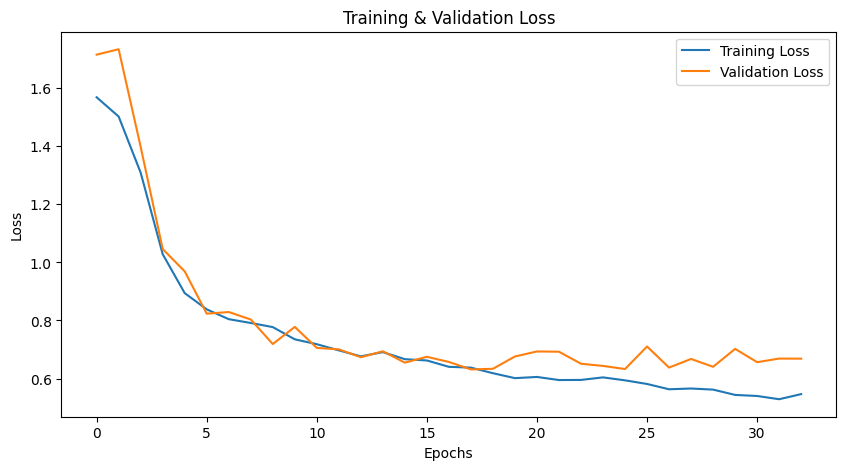

In [12]:
EPOCHS = 400
PATIENCE = 15 


window_size = 24
batch_size = 64
lr = 1e-3
hidden = 128
layers = 3
conv_out_channels = 128

model, val_loader, X_val, Y_val,  _, _, Y_val = train_model(W=window_size, BS=batch_size, epochs=EPOCHS, lr=lr,
                                               patience=PATIENCE, hidden=hidden, n_layers=layers, conv_out=conv_out_channels)

In [13]:
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds.append(model(xb).exp().cpu().numpy())
        trues.append(yb.cpu().numpy())
P = np.vstack(preds)   
Q = np.vstack(trues)   
print("Mean JS divergence:", js_divergence(P, Q).mean())

#Baseline: prever a distribuição média de treino (sem ONI)
baseline = Y_train.mean(axis=0, keepdims=True).numpy()       
B = np.repeat(baseline, len(Q), axis=0)              
print("Baseline JS divergence:", js_divergence(B, Q).mean())

mae_per_cluster = abs(P - Q).mean()*100
print(f"MAE per cluster: {mae_per_cluster:.4f}%")

mae_per_cluster = abs(P - Q).mean(axis=0)*100
mae_df = pd.DataFrame({
    'MAE (%)': mae_per_cluster
})
mae_df.plot.bar()

Mean JS divergence: 0.16343735


NameError: name 'Y_train' is not defined